In [1]:
pip install unidecode scikit-learn BeautifulSoup4 pandas requests lxml selenium regex

Note: you may need to restart the kernel to use updated packages.


In [19]:
from sklearn.preprocessing import StandardScaler
from requests.auth import HTTPBasicAuth
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import numpy as np
import unidecode
import requests
import locale
import pickle
import json
import re 
import lxml
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

##  1. Get the film data from the website

The reasons why I chose the following features:
1. It's easy to manage numerical and categorical values for future predictions.
2. After going through several online projects regarding movie predictions, I found the most commonly used features from IMDb datasets to be `languages`, `budgets`, `genres`, `runtime`, `vote_average`, `vote_count`.
3. After checking the SensCritique website, I found features that might be useful for prediction. 
   1. The chosen features:
      1. Numerical: `ranking`, `year`, `duration`, `stars`, `favorites`, `saves`, `number of critiques`.
      2. Categorical: `director`, `genres`, `group`, `country of origin (pays d'origine)`.
      3. Other: `original_title` could be used to create a linked table with information from IMDb datasets.
   2. The features that I did not choose:
      1. `Synopsis`: Requires further NLP (Natural Language Processing) analysis, which could make it challenging to process and find a link to the ranking.

In [31]:
search_dict_main_page = {
    'rating': {'name': 'div', 'attrs': {"data-testid": "Rating"}},
    'director': {'name': 'a', 'attrs': {"data-testid": "link"}},
    'duration': {'name': 'span', 'attrs': {"data-testid": "duration"}},
    'genres': {'name': 'span', 'attrs': {"data-testid": "genres"}},
    'ranking': {'name': 'span', 'attrs':{'data-testid': 'product-title-wrapper'}}
}

search_dict_film_page = {
    'film_year': {'name': 'p', 'attrs': {"class": "Text__SCTitle-sc-1aoldkr-1 CoverProductInfos__StyledText-sc-1un0kh1-13 eGhlHy jugtWW"}},
    'original_title':{'name': 'p', 'attrs': {"class": "Text__SCTitle-sc-1aoldkr-1 CoverProductInfos__StyledText-sc-1un0kh1-13 eGhlHy kuMSsq"}}
}


In [47]:
class RequestSensCritique:
    def __init__(self):
        self._base_urls = 'https://www.senscritique.com/'
    
    def create_soup(self, content, is_url=True):
        if is_url:
            page_content = requests.get(content).content
        else:
            page_content = content
        
        return BeautifulSoup(page_content, "html.parser")

    def find_text(self, element, search_criteria):
        found_element = element.find(**search_criteria)
        return found_element.text if found_element else None

    def get_full_page(self, link):
        full_url = self._base_urls + link
        driver = webdriver.Chrome()

        try:
            driver.get(full_url)

            for _ in range(8):
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
            
            page_source = driver.page_source

        finally:
            driver.quit()

        return self.create_soup(page_source, is_url=False)
        
    def get_film_page_info(self, film_link, dict_name):
        film_url = self._base_urls + film_link
        film_page_soup = self.create_soup(film_url)

        film_page_dict = {key: self.find_text(film_page_soup, criteria) for key, criteria in dict_name.items()}

        stats_elements = film_page_soup.select('p.Text__SCText-sc-1aoldkr-0.Stats__Text-sc-1u6v943-2.gATBvI')
        if len(stats_elements) == 3:
            film_page_dict['stars'] = stats_elements[0].text
            film_page_dict['saves'] = stats_elements[1].text
            film_page_dict['favorites'] = stats_elements[2].text
        
        critique_number_text = film_page_soup.select('.NavigationTab__WrapperTextStyled-sc-18dtd9d-7')[2].text
        film_page_dict['critique_number'] = int(critique_number_text.split('(')[-1].split(')')[0])

        # certain movies do not have film_group and origin_country
        group_label = film_page_soup.find('span', string='Groupe : ')
        if group_label:
            film_page_dict['film_group'] = group_label.find_next('a', {'class': 'Text__SCText-sc-1aoldkr-0 Link__PrimaryLink-sc-1v081j9-0 gATBvI bGxijB'}).text

        country_label = film_page_soup.find('h3', string=re.compile('Pays d\'origine :'))
        if country_label:
            film_page_dict['origin_country'] = country_label.find_next_sibling('span').get_text()
        
        return film_page_dict
    
    def get_main_page(self, link, main_dict, film_info_dict):
        film_soup = self.get_full_page(link)

        films = film_soup.find_all('div', class_="ProductListItem__Wrapper-sc-1jkxxpj-1 kusRkg")

        all_films_dict = {}

        for film in films:
            title = self.find_text(film, {'name': 'a', 'attrs': {"data-testid": "product-title"}})

            new_film_dict = {key: self.find_text(film, criteria) for key, criteria in main_dict.items()}

            film_link = film.find('a', {"data-testid": "product-title"})['href']
            new_film_dict.update(self.get_film_page_info(film_link, film_info_dict))
            
            all_films_dict[title] = new_film_dict
        
        return all_films_dict


In [48]:
create_request = RequestSensCritique()

top_111_link = 'films/tops/top111'
films_info_dict = create_request.get_main_page(top_111_link, search_dict_main_page,search_dict_film_page )

In [49]:
# save the data to the json file
with open('film_info.json', 'w') as json_file:
    json.dump(films_info_dict, json_file, indent=4)

## 2. Read and Clean the data

### 2.1 Getting to know the data

In [85]:
df = pd.read_json('film_info.json', orient='index')

df.head()

,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country
Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,6.8K,592,Douze hommes en colère,États-Unis
Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon
Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,111,3,Blade Runner,NaN
"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,"
Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon


In [61]:
df.sample(5,random_state=2000)

,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country
Psychose (1960),8.3,Alfred Hitchcock,1 h 49 min.,Thriller,26. Psychose (1960),1960,Psycho,51.7K,12.4K,3.7K,342,Psychose,États-Unis
Vivre (1952),8.1,Akira Kurosawa,2 h 23 min.,Drame,77. Vivre (1952),1952,Ikiru,2.5K,4.2K,423,45,Vivre,Japon
Gentleman Jim (1942),8.1,Raoul Walsh,1 h 44 min.,"Biopic, Sport, Romance",70. Gentleman Jim (1942),1942,None,1.1K,2K,223,36,NaN,États-Unis
L'Opérateur (1928),8.0,Buster Keaton,1 h 16 min.,"Comédie, Romance, Drame",108. L'Opérateur (1928),1928,The Cameraman,2.3K,2.2K,247,25,NaN,États-Unis
Sherlock Junior (1924),8.3,Buster Keaton,45 min.,"Muet, Comédie, Action",18. Sherlock Junior (1924),1924,Sherlock Jr.,3.7K,3.3K,577,44,NaN,États-Unis


Noticed Problems from the sample:
1. The first column should be named as `title`, and we should delete the year from the title.
2. `duration` should be converted to `int` for future analysis. For example, `1 h 36 min.` should be converted to `96`.
3. `genres` should use the `exploded` function to save them to separate rows.
4. `stars`, `saves`, and `favorites` should be converted to numerical values.

Check the categorical data.

In [155]:
df['origin_country'].value_counts()

origin_country
États-Unis          44
Japon               15
États-Unis,          8
France               8
France,              5
Allemagne            4
Italie,              4
Union Soviétique     4
Royaume-Uni,         3
Corée du Sud         3
Royaume-Uni          3
Suède                2
Danemark             2
Japon,               2
Suisse,              1
Hongrie,             1
Cuba,                1
Name: count, dtype: int64

We need to delete the commas in the column of `origin_country`.

In [157]:
df['director'].value_counts()

director
Akira Kurosawa          7
Fritz Lang              4
Charlie Chaplin         4
Sidney Lumet            3
Alfred Hitchcock        3
                       ..
Jean-Pierre Melville    1
Charles Laughton        1
Irvin Kershner          1
Park Chan-Wook          1
Werner Herzog           1
Name: count, Length: 68, dtype: int64

In [158]:
df['genres'].value_counts()

genres
Drame                           17
Drame, Guerre                    6
Policier, Drame, Thriller        5
Historique, Guerre               3
Drame, Thriller                  3
                                ..
Muet, Drame, Science-fiction     1
Drame, Historique, Aventure      1
Drame, Science-fiction           1
Cinéma                           1
Comédie, Romance, Drame          1
Name: count, Length: 66, dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Douze Hommes en colère (1957) to Leçons de ténèbres (1992)
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rating           111 non-null    float64
 1   director         111 non-null    object 
 2   duration         111 non-null    object 
 3   genres           109 non-null    object 
 4   ranking          111 non-null    object 
 5   film_year        111 non-null    int64  
 6   original_title   83 non-null     object 
 7   stars            111 non-null    object 
 8   saves            111 non-null    object 
 9   favorites        111 non-null    object 
 10  critique_number  111 non-null    int64  
 11  film_group       57 non-null     object 
 12  origin_country   110 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 12.1+ KB


Summaries from the info:
1. There are two films that don't have `genres`, check the website to validate the correctness. -> They don't have genres on the website as well.
2. `film_group` has lots of empty data, so I won't use it to do the prediction.

In [89]:
empty_genres = df[df['genres'].isna()]

empty_genres.head()

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title
74,Le Joli Mai (1963),8.1,Chris Marker,2 h 16 min.,None,75. Le Joli Mai (1963),1963,None,1.6K,2.2K,242,27,NaN,France,Le Joli Mai
84,Paris Is Burning (1991),8.1,Jennie Livingston,1 h 11 min.,None,85. Paris Is Burning (1991),1991,None,2.1K,2.2K,301,10,NaN,États-Unis,Paris Is Burning


In [90]:
df['rating'].describe()

count    111.000000
mean       8.169369
std        0.152430
min        8.000000
25%        8.100000
50%        8.100000
75%        8.200000
max        8.700000
Name: rating, dtype: float64

### 2.2 Clean the Data
Based on what I've observed from the sample data.

In [86]:
# name the first column to title
df.reset_index(inplace=True)

df.rename(columns={'index': 'title'}, inplace=True)


In [87]:
# clean the title without the year
def clean_title(title):
    return re.sub(r' \(\d{4}\)', '', title)
  
    
df['clean_title'] = df['title'].apply(clean_title)

df.head()


,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,111,3,Blade Runner,NaN,Blade Runner : The Final Cut
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand"
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse


In [91]:
# convert duration to numerique values
def convert_to_minutes(duration_str):
    parts = duration_str.split()
    hours = int(parts[0])
    minutes = int(parts[-2])
    total_minutes = hours * 60 + minutes

    return total_minutes

df['duration_minutes'] = df['duration'].apply(convert_to_minutes)

df.head(5)

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title,duration_minutes
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri,133
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,111,3,Blade Runner,NaN,Blade Runner : The Final Cut,117
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse,185


In [92]:
# get ranking number from ranking column
df['ranking_number'] = df['ranking'].str.split('.').str.get(0)

df.head(5)

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri,133,2
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,111,3,Blade Runner,NaN,Blade Runner : The Final Cut,117,3
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse,185,5


In [161]:
# delete the commas in the column of `origin_country`.
df['origin_country_clean'] = df['origin_country'].str.replace(',', ' ')

# clean the extra space here
df['origin_country_clean'] = df['origin_country_clean'].str.strip()

df['origin_country_clean'].value_counts()


origin_country_clean
États-Unis          52
Japon               17
France              13
Royaume-Uni          6
Italie               4
Union Soviétique     4
Allemagne            4
Corée du Sud         3
Suède                2
Danemark             2
Cuba                 1
Hongrie              1
Suisse               1
Name: count, dtype: int64

In [96]:
# convert stars, saves favorites to numbers
def deal_with_k(number_str):
    if 'K' in number_str:
        parts = number_str.split('K')[0]
        return int(float(parts) * 1000)
    else:
        return int(number_str)

df['stars_number'] = df['stars'].apply(deal_with_k)
df['saves_number'] = df['saves'].apply(deal_with_k)
df['favorites_number'] = df['favorites'].apply(deal_with_k)

df.head(5)


,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,...,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number,genres_split,stars_number,saves_number,favorites_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,...,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,"[Policier, Drame]",51700,16300,6800
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,...,115,Hara-Kiri,Japon,Harakiri,133,2,[Drame],8200,12700,1500
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,...,3,Blade Runner,NaN,Blade Runner : The Final Cut,117,3,[Science-fiction],1200,269,111
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,...,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4,"[Western, Aventure]",54400,13600,5500
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,...,88,Barberousse,Japon,Barberousse,185,5,[Drame],4300,7700,834


In [97]:
# using explode function to process genres
df['genres_split'] = df['genres'].str.split(', ')
df_genre = df.explode('genres_split')

df_genre.head(5)

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,...,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number,genres_split,stars_number,saves_number,favorites_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,...,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,Policier,51700,16300,6800
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,...,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,Drame,51700,16300,6800
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,...,115,Hara-Kiri,Japon,Harakiri,133,2,Drame,8200,12700,1500
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,...,3,Blade Runner,NaN,Blade Runner : The Final Cut,117,3,Science-fiction,1200,269,111
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,...,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4,Western,54400,13600,5500


In [144]:
df.head()

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,...,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number,genres_split,stars_number,saves_number,favorites_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.7K,16.3K,...,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,"[Policier, Drame]",51700,16300,6800
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,...,115,Hara-Kiri,Japon,Harakiri,133,2,[Drame],8200,12700,1500
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,269,...,3,Blade Runner,NaN,Blade Runner : The Final Cut,117,3,[Science-fiction],1200,269,111
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.4K,13.6K,...,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4,"[Western, Aventure]",54400,13600,5500
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,...,88,Barberousse,Japon,Barberousse,185,5,[Drame],4300,7700,834


## 3. The Movie Popularity Prediction 

### 3.1 Prepare the dataframes for prediction

The reason I selected these features is to analyze the ratings and rankings on this website more effectively. These may be influenced by preferences towards specific directors or countries. 

Additionally, by examining these features, we might uncover relationships between the ratings and various factors such as the number of stars, saves, favorites, and critiques.

In [150]:
features_df = df[['director','origin_country', 'genres', 'duration_minutes','stars_number','saves_number','favorites_number','critique_number','film_year']]

labels_df = df[['ranking_number', 'rating']]

Have a look at the dataset and drop values that would be outliers.

In [151]:
features_df.head()

,director,origin_country,genres,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year
0,Sidney Lumet,États-Unis,"Policier, Drame",96,51700,16300,6800,592,1957
1,Masaki Kobayashi,Japon,Drame,133,8200,12700,1500,115,1962
2,Ridley Scott,NaN,Science-fiction,117,1200,269,111,3,2007
3,Sergio Leone,"Italie,","Western, Aventure",179,54400,13600,5500,379,1966
4,Akira Kurosawa,Japon,Drame,185,4300,7700,834,88,1965


In [146]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            111 non-null    float64
 1   director          111 non-null    object 
 2   origin_country    110 non-null    object 
 3   duration_minutes  111 non-null    int64  
 4   stars_number      111 non-null    int64  
 5   saves_number      111 non-null    int64  
 6   favorites_number  111 non-null    int64  
 7   critique_number   111 non-null    int64  
 8   film_year         111 non-null    int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 7.9+ KB


In [152]:
features_df.describe()

,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,238.828829,26106.477477,8022.243243,2250.738739,177.621622,1967.495495
std,509.752291,40807.414610,5408.640766,2833.325459,188.195694,24.196121
min,64.000000,875.000000,269.000000,93.000000,3.000000,1921.000000
25%,108.000000,2500.000000,4000.000000,377.500000,42.500000,1953.000000
50%,132.000000,8200.000000,6600.000000,1000.000000,97.000000,1965.000000
75%,173.000000,35500.000000,11200.000000,2900.000000,251.000000,1985.000000
max,3294.000000,246700.000000,27600.000000,14100.000000,918.000000,2019.000000


In [153]:
features_df['origin_country'].value_counts()

origin_country
États-Unis          44
Japon               15
États-Unis,          8
France               8
France,              5
Allemagne            4
Italie,              4
Union Soviétique     4
Royaume-Uni,         3
Corée du Sud         3
Royaume-Uni          3
Suède                2
Danemark             2
Japon,               2
Suisse,              1
Hongrie,             1
Cuba,                1
Name: count, dtype: int64

In [121]:
# Delete the outilers for the `critique_number`.
features_df = features_df[features_df['critique_number']<5]

In [130]:
# Important step to ensure the labels align with the features.
labels_df = labels_df[features_df.index]
labels_df.head()

0    1
1    2
2    3
3    4
4    5
Name: ranking_number, dtype: object

In [149]:
# we assume that they have the same length
assert len(features_df) == len(labels_df)

### 3.2 Exploratory Data Analysis

In [132]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state = 42)

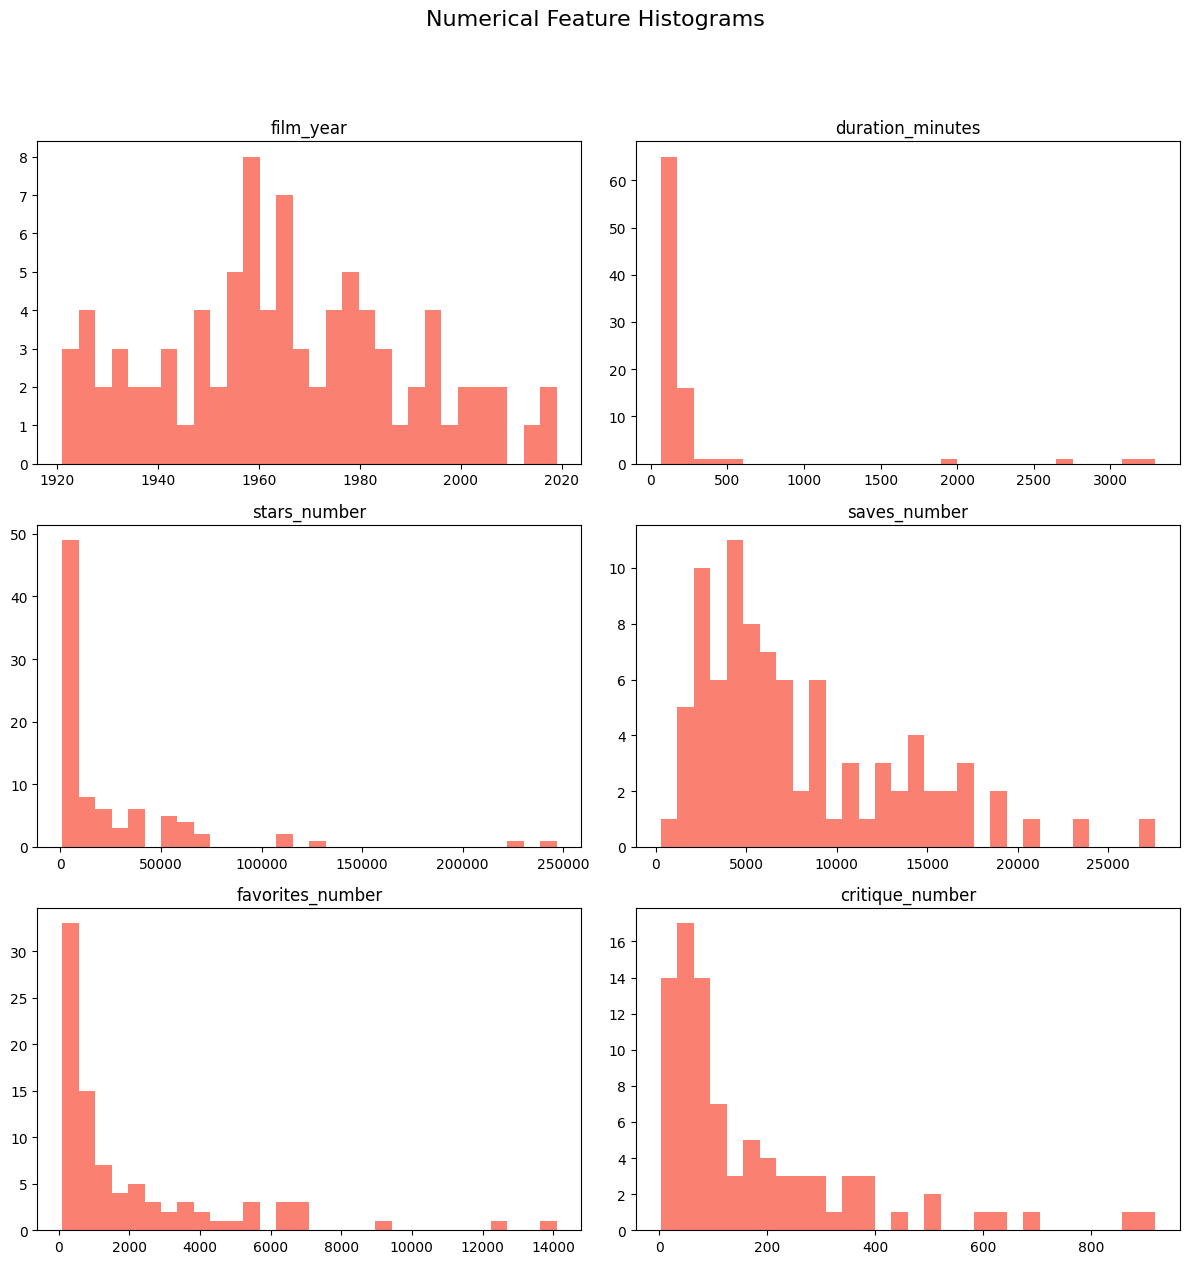

In [139]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12, 12

fig, axs = plt.subplots(3, 2)
fig.suptitle('Numerical Feature Histograms', y=1.05, fontsize=16)

axs[0, 0].hist(x_train['film_year'].values, bins=30, color='salmon')
axs[0, 0].set_title('film_year')

axs[0, 1].hist(x_train['duration_minutes'].values, bins=30, color='salmon')
axs[0, 1].set_title('duration_minutes')

axs[1, 0].hist(x_train['stars_number'].values, bins=30, color='salmon')
axs[1, 0].set_title('stars_number')

axs[1, 1].hist(x_train['saves_number'].values, bins=30, color='salmon')
axs[1, 1].set_title('saves_number')

axs[2, 0].hist(x_train['favorites_number'].values, bins=30, color='salmon')
axs[2, 0].set_title('favorites_number')

axs[2, 1].hist(x_train['critique_number'].values, bins=30, color='salmon')
axs[2, 1].set_title('critique_number')

plt.tight_layout()
plt.show()

Except for `film_year`, other plots seem to be skewed distribution. 

In [145]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# MultiLabelBinarizer for genres
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(features_df['genres'])

# Adding encoded genres back to the DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
features_df = pd.concat([features_df, genres_df], axis=1).drop(columns=['genres'])

# Defining columns to be one-hot encoded
categorical_cols = ['director', 'origin_country']

# Column transformer that will allow us to preprocess the data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)],
    remainder='passthrough'
)

# Defining the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features_df, labels_df, test_size=0.2, random_state=42)

# Fitting the model
model.fit(X_train, y_train.values.ravel())

# Making predictions
y_pred = model.predict(X_test)

# Calculate the error
error = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {error}")


KeyError: 'genres'